# Data Input and preprocessing

In [96]:
from nbtschematic import SchematicFile
import os
import numpy as np
from scipy.ndimage import zoom

tower_path = '../data/tower/'
arena_path = '../data/arena/'

# tower is 1 and arena is 0
target = []
data = []

# resize all the building to the same size
resize = 64

# for tower 3D model
for filename in os.listdir(tower_path):
    if ".schematic" not in filename:
        continue
    
    sf = SchematicFile.load(tower_path + filename)
    
    X = sf.blocks.shape[0]
    Y = sf.blocks.shape[1]
    Z = sf.blocks.shape[2]
    
    temp_arr = np.zeros((X, Y, Z, 3))
    for i in range(X):
        for j in range(Y):
            for k in range(Z):
                block_id = sf.blocks[i, j, k]
                
                # we only care about concrete block and air block
                # use [0, 0, 0] for air block color
                # use [1, 1, 1] for concrete block color
                if block_id == 0:
                    temp_arr[i][j][k] = [0, 0, 0]
                else:
                    temp_arr[i][j][k] = [1, 1, 1]
    
    temp_arr = zoom(temp_arr, (resize / X, resize / Y, resize / Z, 1))
    
    data.append(temp_arr)
    target.append(1)

In [97]:
# for tower 3D model
for filename in os.listdir(arena_path):
    if ".schematic" not in filename:
        continue
    
    sf = SchematicFile.load(arena_path + filename)
    
    X = sf.blocks.shape[0]
    Y = sf.blocks.shape[1]
    Z = sf.blocks.shape[2]
    
    temp_arr = np.zeros((X, Y, Z, 3))
    for i in range(X):
        for j in range(Y):
            for k in range(Z):
                block_id = sf.blocks[i, j, k]
                
                # we only care about concrete block and air block
                if block_id == 0:
                    temp_arr[i][j][k] = [0, 0, 0]
                else:
                    temp_arr[i][j][k] = [1, 1, 1]
    
    temp_arr = zoom(temp_arr, (resize / X, resize / Y, resize / Z, 1))
    
    data.append(temp_arr)
    target.append(0)

In [98]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

sample_data = np.copy(data)
sample_target = np.copy(target)

# traing-test-split 7:3
training_sample, testing_sample, training_target, testing_target = train_test_split(sample_data, sample_target, test_size = 0.3) 

# reshape
training_sample = training_sample.reshape(70,3,resize,resize,resize)
testing_sample = testing_sample.reshape(30,3,resize,resize,resize)

# Data Visualization

11604


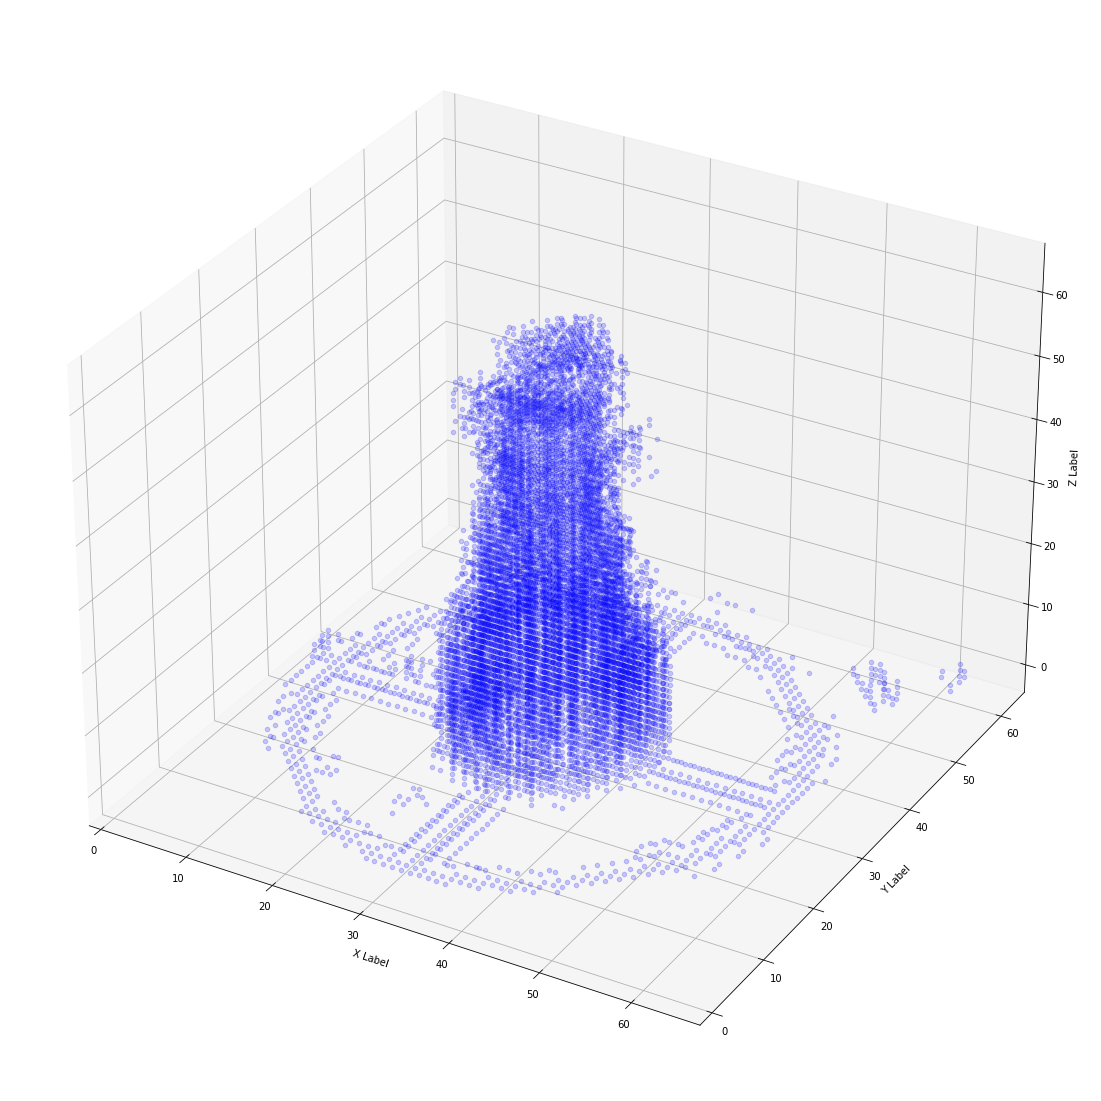

In [200]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# pick one tower
tower = sample_data[32]
X, Y, Z, color = tower.shape

concrete = []
air = []

for x in range(X):
    for y in range(Y):
        for z in range(Z):
            if tower[x][y][z][0] > 1e-2:
                concrete.append([x, y, z])
            else:
                air.append([x, y, z])
                
print(len(concrete))
                
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')

for c in concrete:
    ax.scatter(c[2], c[1], c[0], color="blue", alpha=0.2)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

25183


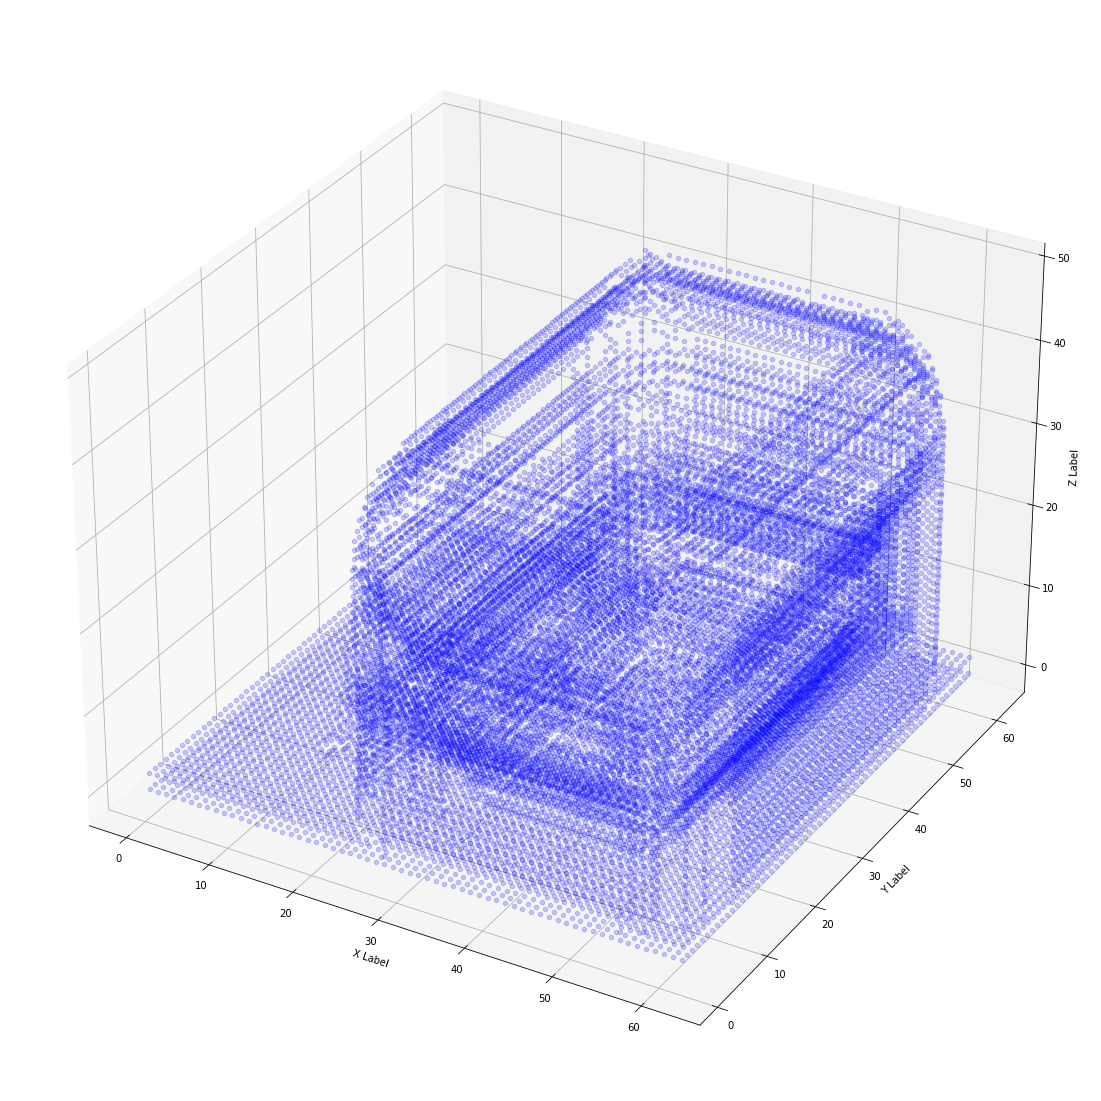

In [201]:
# pick one arena
tower = sample_data[60]
X, Y, Z, color = tower.shape

concrete = []
air = []

for x in range(X):
    for y in range(Y):
        for z in range(Z):
            if tower[x][y][z][0] > 1e-2:
                concrete.append([x, y, z])
            else:
                air.append([x, y, z])
print(len(concrete))
                
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')

for c in concrete:
    ax.scatter(c[2], c[1], c[0], color="blue", alpha=0.2)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# Model Construction

In [99]:
print(training_sample.shape)

train_x = torch.from_numpy(training_sample).float()
train_y = torch.from_numpy(training_target).long()

test_x = torch.from_numpy(testing_sample).float()
test_y = torch.from_numpy(testing_target).long()

# batch_size, epoch and iteration
batch_size = 10

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(train_x,train_y)
test = torch.utils.data.TensorDataset(test_x,test_y)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

(70, 3, 64, 64, 64)


In [104]:
num_classes = 2

# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(3, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(175616, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)        
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=0),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer
    

    def forward(self, x):
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

#Definition of hyperparameters
n_iters = 100
num_epochs = n_iters / (len(train_x) / batch_size)
num_epochs = int(num_epochs)

# Create CNN
model = CNNModel()
#model.cuda()
print(model)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

CNNModel(
  (conv_layer1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=175616, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (batch): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.15, inplace=False)
)


# Model Training

In [ ]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(10,3,resize,resize,resize))
        labels = Variable(labels)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        
        count += 1
        if count % 5 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(10,3,resize,resize,resize))
                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 5 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))